## Finite Sample Properties of Linear GMM



### Introduction



GMM provides a generalized way to think about instrumental
variables estimators, and we also have evidence that the finite
sample properties of these estimators may be poor.  Here we&rsquo;ll
construct a simple Monte Carlo framework within which to evaluate
the finite-sample behavior of GMM linear IV estimators.



### Asymptotic Variance of GMM estimator



If we have $\mbox{E}g_j(\beta)g_j(\beta)^\top=\Omega$ and
$\mbox{E}\frac{\partial g_j}{\partial b^\top}(\beta)=Q$ then we&rsquo;ve
seen that the asymptotic variance of the optimally weighted GMM
estimator is
$$
       V_b = \left(Q^\top\Omega^{-1}Q\right)^{-1}.
   $$



### Data Generating Process



We consider the linear IV model

\begin{align*}
   y &= X\beta + u\\
   \mbox{E}Z^\top u &= 0
\end{align*}

Thus, we need to describe processes that generate $(X,Z,u)$.

The following code block defines the important parameters governing
the DGP; this is the &ldquo;TRUTH&rdquo; we&rsquo;re designing tools to reveal.  



In [1]:
import numpy as np
from numpy.linalg import inv

## Play with us!
beta = 1     # "Coefficient of interest"
gamma = 1    # Governs effect of u on X
sigma_u = 1  # Note assumption of homoskedasticity
## Play with us!

# Let Z have order ell, and X order 1, with Var([X,Z]|u)=VXZ

ell = 4 # Play with me too!

# Arbitrary (but deterministic) choice for VXZ = [VX Cov(X,Z);
#                                                 Cov(Z,X) VZ]
# Pinned down by choice of a matrix A...
A = np.sqrt(1/np.arange(1,(ell+1)**2+1)).reshape((ell+1,ell+1))

## Below here we're less playful.

# Now Var([X,Z]|u) is constructed so guaranteed pos. def.
VXZ = A.T@A

Q = -VXZ[1:,[0]]  # -EZX', or generally Edgj/db'

# Gimme some truth:
truth = (beta,gamma,sigma_u,VXZ)

## But play with Omega if you want to introduce heteroskedascity
Omega = (sigma_u**2)*VXZ[1:,1:] # E(Zu)(u'Z')

# Asymptotic variance of optimally weighted GMM estimator:
AVar_b = inv(Q.T@inv(Omega)@Q)

AVar_b

array([[0.73115722]])

Now code to generate $N$ realizations of $(y,X,Z)$ given some &ldquo;truth&rdquo;
`(beta,gamma,sigma_u,VXZ)`:



In [2]:
from scipy.stats import distributions as iid

def dgp(N,beta,gamma,sigma_u,VXZ):
    """Generate a tuple of (y,X,Z).

    Satisfies model:
        y = X@beta + u
        E Z'u = 0
        Var(u) = sigma^2
        Cov(X,u) = gamma*sigma_u^2
        Var([X,Z]|u) = VXZ
        u,X,Z mean zero, Gaussian

    Each element of the tuple is an array of N observations.

    Inputs include
    - beta :: the coefficient of interest
    - gamma :: linear effect of disturbance on X
    - sigma_u :: Variance of disturbance
    - VXZ :: Var([X,Z]|u)
    """

    u = iid.norm.rvs(size=(N,1))*sigma_u

    # "Square root" of VXZ via eigendecomposition
    lbda,v = np.linalg.eig(VXZ)
    SXZ = v@np.diag(np.sqrt(lbda))

    # Generate normal random variates [X*,Z]
    XZ = iid.norm.rvs(size=(N,VXZ.shape[0]))@SXZ.T

    # But X is endogenous...
    X = XZ[:,[0]] + gamma*u
    Z = XZ[:,1:]

    # Calculate y
    y = X*beta + u

    return y,X,Z

Check on DGP:



In [3]:
N = 10000

data = dgp(N,*truth)

y,X,Z = data # Unpack tuple to check on things

# Check that we've computed things correctly:
print("True Var([X,Z]|u):")
print(VXZ,end="\n\n")

print("Estimated (unconditional) sample covariance matrix minus true conditional:")
print(np.cov(np.c_[X,Z].T,ddof=0) - VXZ)

True Var([X,Z]|u):
[[1.36769481 1.05560708 0.90973918 0.81856253 0.75370821]
 [1.05560708 0.83046855 0.72356461 0.65585413 0.60715898]
 [0.90973918 0.72356461 0.63429023 0.57728783 0.53602129]
 [0.81856253 0.65585413 0.57728783 0.52683793 0.49014636]
 [0.75370821 0.60715898 0.53602129 0.49014636 0.45666667]]

Estimated (unconditional) sample covariance matrix minus true conditional:
[[1.02536347 0.01204868 0.00992294 0.00863064 0.00773667]
 [0.01204868 0.00277004 0.00241481 0.00219312 0.00203626]
 [0.00992294 0.00241481 0.00219551 0.00205302 0.00194836]
 [0.00863064 0.00219312 0.00205302 0.0019565  0.00188207]
 [0.00773667 0.00203626 0.00194836 0.00188207 0.00182751]]


### Estimation



Now that we have a data-generating process we proceed under
   the conceit that we can observe samples generated by this process,
   but otherwise temporarily &ldquo;forget&rdquo; the properties of the DGP, and use the
   generated data to try to reconstruct aspects of the DGP.

In our example, we consider using the optimally weighted linear IV
estimator, and define a function which computes observation-level
deviations from expectations for this model. To estimate a different
model this is the function we&rsquo;d want to re-define `gj`.



In [4]:
import numpy as np
from numpy.linalg import inv

def gj(b,y,X,Z):
    """Observations of g_j(b).

    This defines the deviations from the predictions of our model; i.e.,
    e_j = Z_ju_j, where EZ_ju_j=0.

    Can replace this function to testimate a different model.
    """
    return Z*(y - X*b)

#### Construct sample moments



Begin by defining a function to construct the sample moments given
    the data and a parameter estimate $b$:



In [5]:
def gN(b,data):
    """Averages of g_j(b).

    This is generic for data, to be passed to gj.
    """
    e = gj(b,*data)

    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1], "Need more observations than moments!"
    
    return e.mean(axis=0)

#### Define estimator of Egg&rsquo;



Next we define a function to compute covariance matrix of moments.
Re-centering can be important in finite samples, even if irrelevant in
the limit.  Since we have $\mbox{E}g_j(\beta)=0$ under the null we may
as well use this information when constructing our weighting matrix.



In [6]:
def Omegahat(b,data):
    e = gj(b,*data)

    # Recenter! We have Eu=0 under null.
    # Important to use this information.
    e = e - e.mean(axis=0) 
    
    return e.T@e/e.shape[0]

Check construction of weighting matrix for our data at true parameter
$\beta$.  Note that we&rsquo;re &ldquo;cheating&rdquo; here, since our construction of
`Winv` relied on knowledge of the true parameter $\beta$ (this is
sometimes called an &ldquo;Oracle estimator&rdquo;).  We&rsquo;ll play fair a bit later.



In [7]:
Winv = Omegahat(beta,data) 
print(Winv)

[[0.8051672  0.70280452 0.63785095 0.59106385]
 [0.70280452 0.61728976 0.5625706  0.5228842 ]
 [0.63785095 0.5625706  0.51411643 0.47880575]
 [0.59106385 0.5228842  0.47880575 0.44656875]]


Define the criterion function given a weighting matrix $W$:



In [8]:
def J(b,W,data):

    m = gN(b,data) # Sample moments @ b
    N = data[0].shape[0]

    return (N*m.T@W@m) # Scale by sample size

Next, check construction of criterion given our data.  We want
something that looks nice and quadratic, at least in the neighborhood
of $\beta$.  Note that comparing the criterion to the critical values
of the $\chi^2$ statistic gives us an alternative way to construct
confidence intervals.



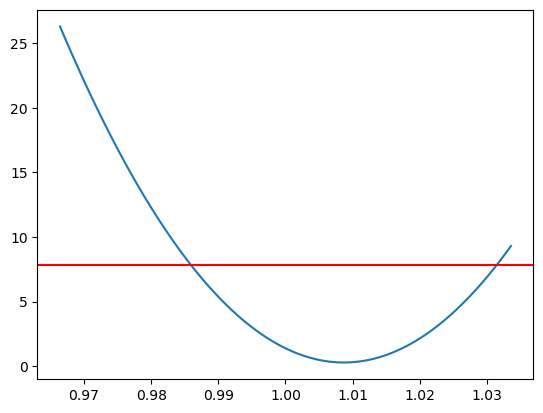

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

# Limiting distribution of criterion (under null)
limiting_J = iid.chi2(ell-1)

# Limiting SE of b
sigma_0 = lambda N: np.sqrt(inv(Q.T@inv(Winv)@Q)/N)[0][0] 

# Choose 8 sigma_0 neighborhood of "truth"
B = np.linspace(beta-4*sigma_0(N),beta+4*sigma_0(N),100)
W = inv(Winv)

_ = plt.plot(B,[J(b,W,data) for b in B.tolist()])
_ = plt.axhline(limiting_J.isf(0.05),color='r')

#### Two Step Estimator



For the figure above we used an &ldquo;Oracle&rdquo; estimate of the optimal
    weighting matrix.  This was only for pedagogical purposes.  We
    next implement the two-step GMM estimator.  If we needed to
    estimate more than a single scalar parameter we&rsquo;d need a different
    minimization routine (we do this in `gmm.py`).



In [10]:
from scipy.optimize import minimize_scalar

def two_step_gmm(data):

    # First step uses identity weighting matrix
    W1 = np.eye(gj(1,*data).shape[1])

    b1 = minimize_scalar(lambda b: J(b,W1,data)).x 

    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = inv(Omegahat(b1,data))

    return minimize_scalar(lambda b: J(b,W2,data))

Now let&rsquo;s try it with an actual sample, just to see that things work:



In [11]:
soltn = two_step_gmm(data)

print("b=%f, J=%f, Critical J=%f" % (soltn.x,soltn.fun,limiting_J.isf(0.05)))

b=1.008690, J=0.291431, Critical J=7.814728


### Monte Carlo Experiment



Now our experiment begins.  We set our frequentist hats firmly on our
heads, and draw repeated samples of data, each generating a
corresponding estimate of beta.  Then the empirical distribution of
these samples tells us about the *finite* sample performance of our estimator.

We&rsquo;ll generate a sample of estimates of $b$ by drawing repeated
samples of size $N$:



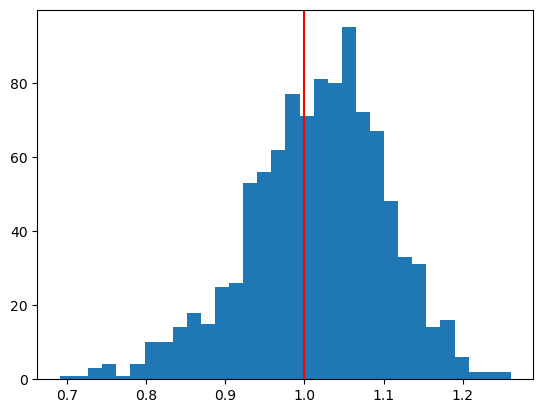

In [16]:
N = 100 # Sample size

D = 1000 # Monte Carlo draws

b_draws = []
J_draws = []
for d in range(D):
    soltn = two_step_gmm(dgp(N,*truth))
    b_draws.append(soltn.x)
    J_draws.append(soltn.fun)

_ = plt.hist(b_draws,bins=int(np.ceil(np.sqrt(D))))
_ = plt.axvline(beta,color='r')

### Distribution of Monte Carlo draws vs. Asymptotic distribution



Compare Monte Carlo standard errors with asymptotic approximation:



In [17]:
# Limiting distribution of estimator

limiting_b = iid.norm(loc=beta,scale=sigma_0(N))

print("Monte Carlo standard errors: %g" % np.std(b_draws))
print("Asymptotic approximation: %g" % sigma_0(N))
print("Critical value for J statistic: %g (5%%)" % limiting_J.isf(.05))

Monte Carlo standard errors: 0.0881328
Asymptotic approximation: 0.083926
Critical value for J statistic: 7.81473 (5%)


Now construct probability plot (bootstrapped $b$s vs. quantiles of
limiting distribution):



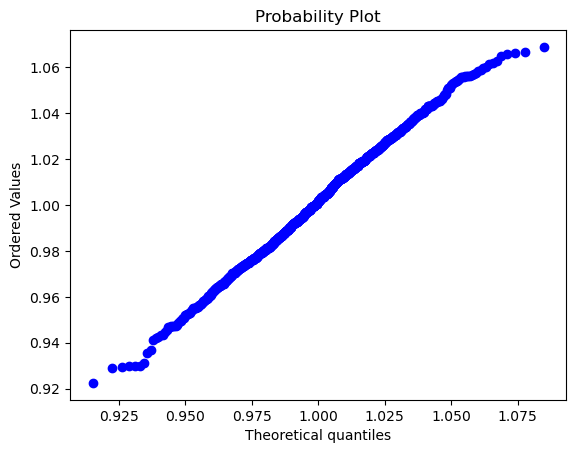

In [14]:
from scipy.stats import probplot

_ = probplot(b_draws,dist=limiting_b,fit=False,plot=plt)

Next, consider the a $p$-$p$ plot for $J$ statistics (recall these
should be distributed $\chi^2_{\ell-1}$).



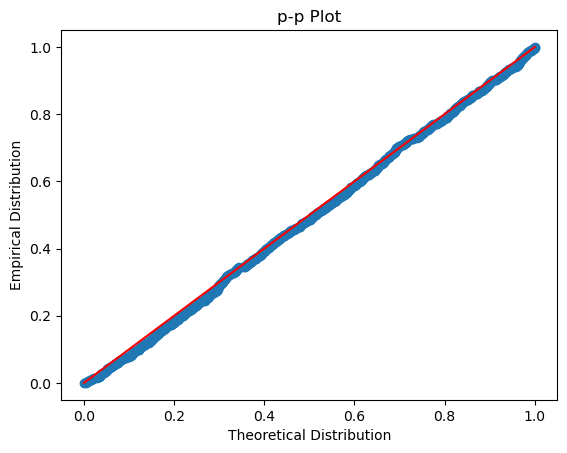

In [15]:
def ppplot(data,dist):
    data = np.array(data)

    # Theoretical CDF, evaluated at points of data
    P = [dist.cdf(x) for x in data.tolist()]

    # Empirical CDF, evaluated at points of data
    Phat = [(data<x).mean() for x in data.tolist()]

    fig, ax = plt.subplots()

    ax.scatter(P,Phat)
    ax.plot([0,1],[0,1],color='r') # Plot 45
    ax.set_xlabel('Theoretical Distribution')
    ax.set_ylabel('Empirical Distribution')
    ax.set_title('p-p Plot')

    return ax

_ = ppplot(J_draws, limiting_J)